# A representative subset of AotM-2011 Playlists with MSD Audio Features

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import gzip
import pickle as pkl
import numpy as np
import pandas as pd
from scipy.optimize import check_grad
from scipy.sparse import lil_matrix, issparse
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('src')
from models import BinaryRelevance
from models import PCMLC, objective
from tools import calc_precisionK, calc_rank, f1_score_nowarn, evalPred, calc_RPrecision_HitRate

In [3]:
data_dir = 'data/aotm2011'
fplaylist = os.path.join(data_dir, 'aotm2011-playlist.pkl.gz')
ffeature = 'data/msd/song2feature.pkl.gz'
fgenre = 'data/msd/song2genre.pkl.gz'
TOPs = [5, 10, 20, 30, 50, 100]#, 200, 300, 500#, 1000]

## Load playlists

Load playlists.

In [4]:
all_playlists = pkl.load(gzip.open(fplaylist, 'rb'))

In [5]:
all_users = sorted(set({user for _, user in all_playlists}))

In [6]:
print('#user    :', len(all_users))
print('#playlist:', len(all_playlists))

#user    : 14182
#playlist: 84710


In [7]:
pl_lengths = [len(pl) for pl, _ in all_playlists]
#plt.hist(pl_lengths, bins=100)
print('Average playlist length: %.1f' % np.mean(pl_lengths))

Average playlist length: 10.1


## Load song features

Load `song_id` --> `feature array` mapping: map a song to the audio features of one of its corresponding tracks in MSD.

In [8]:
song2feature = pkl.load(gzip.open(ffeature, 'rb'))

In [9]:
#mean_age = (np.sum(song_ages) - np.sum(song_ages[missing_ix])) / (len(song_ages) - len(missing_ix))
#mean_age

## Subset of data

The user whose playlists cover a *proper number of playlists*, e.g. 50.

In [10]:
user_playlists = dict()
for pl, u in all_playlists:
    try: 
        user_playlists[u].append(pl)
    except KeyError:
        user_playlists[u] = [pl]

In [11]:
u_npl = sorted([(u, len(user_playlists[u])) for u in all_users], key=lambda x: x[1])

In [12]:
#u_npl

In [13]:
step = 1000  # sample 0.1%
subset = [u_npl[ix] for ix in np.arange(0, len(u_npl), step)]

In [14]:
subset

[((914763600.0, 'Grey'), 1),
 ((1050674400.0, 'World Class Chris'), 1),
 ((1076418000.0, 'Garick'), 1),
 ((1076418000.0, 'Tom Jones'), 1),
 ((1078923600.0, 'Kurt87'), 1),
 ((1115992800.0, 'm12788'), 1),
 ((1190728800.0, 'EvaninCambridge'), 1),
 ((1058364000.0, 'Meg Usta'), 2),
 ((1092578400.0, 'XxPunk4PeacexX'), 2),
 ((1049205600.0, 'hobbitcore'), 3),
 ((1008421200.0, 'Chris Bowron'), 4),
 ((1079787600.0, 'tragic3rdwoman'), 5),
 ((1069246800.0, 'Axelsson'), 8),
 ((1012482000.0, 'lynn*'), 15),
 ((1009198800.0, 'jarød'), 62)]

In [15]:
len(subset)

15

In [16]:
uid_subset = [t[0] for t in subset]

In [17]:
#udf[uid_subset]  # tuple are used as multiindex in pandas
#udf[[uid_subset]]

In [18]:
playlists_subset = [(pl, u) for u in uid_subset for pl in user_playlists[u]]

In [19]:
len(playlists_subset)

108

In [20]:
song_set = sorted([(sid, song2feature[sid][-1]) for sid in {sid for pl, _ in playlists_subset for sid in pl}],
                  key=lambda x: (x[1], x[0]))

In [21]:
print(len(song_set))
#song_set

786


### Split songs for setting I

Split songs (80/20 split) the latest released (year) songs are in dev set ~~such that the distributions of song popularity (the number of occurrence in playlists) in training and dev set are similiar~~.

In [22]:
dev_nsongs = int(len(song_set) * 0.2)
dev_song_set = song_set[:dev_nsongs]
train_song_set = song_set[dev_nsongs:]
print('#songs in training set:', len(train_song_set))
print('#songs in test set    :', len(dev_song_set))

#songs in training set: 629
#songs in test set    : 157


In [23]:
#dev_song_set
#train_song_set

In [24]:
song2index = {sid: ix for ix, (sid, _) in enumerate(song_set)}
song_pl_mat = lil_matrix((len(song_set), len(playlists_subset)), dtype=np.int8)
for j in range(len(playlists_subset)):
    pl = playlists_subset[j][0]
    ind = [song2index[sid] for sid in pl]
    song_pl_mat[ind, j] = 1

In [25]:
song_pop = np.sum(song_pl_mat, axis=1)

In [26]:
song2pop = {sid: song_pop[song2index[sid], 0] for (sid, _) in song_set}

Histogram of song popularity in training set.

629


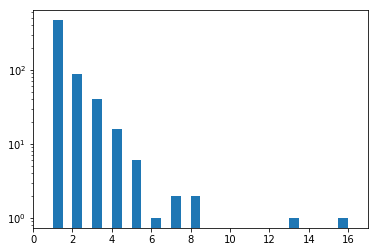

In [27]:
train_song_pop = [song2pop[sid] for (sid, _) in train_song_set]
ax = plt.subplot(111)
ax.hist(train_song_pop, bins=30)
ax.set_yscale('log')
ax.set_xlim(0, song_pop.max()+1)
print(len(train_song_set))

Histogram of song popularity in dev set.

157


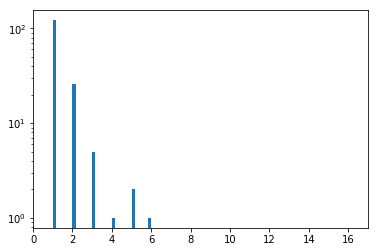

In [28]:
dev_song_pop = [song2pop[sid] for (sid, _) in dev_song_set]
ax = plt.subplot(111)
ax.hist(dev_song_pop, bins=30)
ax.set_yscale('log')
ax.set_xlim(0, song_pop.max()+1)
print(len(dev_song_set))

### Split playlists

Split playlists (80/20 split) uniformly at random ~~such that the distributions of playlist length (the number of songs in playlists) for each user in training and dev set are similiar~~.

In [29]:
train_playlists = []
dev_playlists = []

In [30]:
dev_ratio = 0.2
np.random.seed(987654321)
for u in uid_subset:
    playlists_u = [(pl, u) for pl in user_playlists[u]]
    if len(user_playlists[u]) < 5:
        train_playlists += playlists_u
    else:
        npl_dev  = int(dev_ratio * len(user_playlists[u]))
        pl_indices = np.random.permutation(len(user_playlists[u]))
        dev_playlists  += playlists_u[:npl_dev]
        train_playlists += playlists_u[npl_dev:]

In [31]:
print(len(train_playlists), len(dev_playlists))

91 17


In [32]:
xmax = np.max([len(pl) for pl, _ in playlists_subset]) + 1

Histogram of playlist length in training set.

91


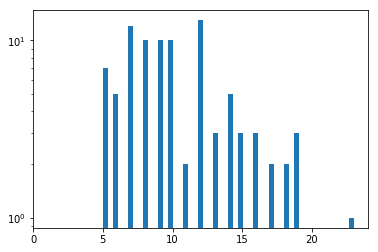

In [33]:
ax = plt.subplot(111)
ax.hist([len(pl) for pl, _ in train_playlists], bins=50)
ax.set_yscale('log')
ax.set_xlim(0, xmax)
print(len(train_playlists))

Histogram of playlist length in training set.

17


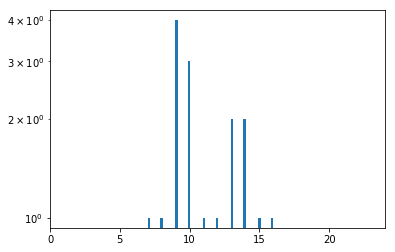

In [34]:
ax = plt.subplot(111)
ax.hist([len(pl) for pl, _ in dev_playlists], bins=50)
ax.set_yscale('log')
ax.set_xlim(0, xmax)
print(len(dev_playlists))

### Hold part of songs in the dev set of playlists

Hold the last half of songs for each playlist in dev set.

In [35]:
dev_playlists_obs = [pl[:-int(len(pl)/2)] for (pl, _) in dev_playlists]
dev_playlists_held = [pl[-int(len(pl)/2):] for (pl, _) in dev_playlists]

In [36]:
for i in range(len(dev_playlists)):
    assert np.all(dev_playlists[i][0] == dev_playlists_obs[i] + dev_playlists_held[i])

In [37]:
print('obs: %d, held: %d' % (np.sum([len(ppl) for ppl in dev_playlists_obs]), 
                             np.sum([len(ppl) for ppl in dev_playlists_held])))

obs: 99, held: 90


## Load genres

In [38]:
song2genre = pkl.load(gzip.open(fgenre, 'rb'))

Check if all songs have genre info.

In [39]:
np.sum([sid in song2genre for sid, _ in song_set])

577

## Create song-playlist matrix

Songs as rows, playlists as columns.

In [40]:
def gen_dataset(playlists, song2feature, song2genre, train_song_set, 
                dev_song_set=[], test_song_set=[], song2pop_train=None):
    """
    Create labelled dataset: rows are songs, columns are users.
    
    Input:
        - playlists: a set of playlists
        - train_song_set: a list of songIDs in training set
        - dev_song_set: a list of songIDs in dev set
        - test_song_set: a list of songIDs in test set
        - song2feature: dictionary that maps songIDs to features from MSD
        - song2genre: dictionary that maps songIDs to genre
        - song2pop_train: a dictionary that maps songIDs to its popularity
    Output:
        - (Feature, Label) pair (X, Y)
          X: #songs by #features
          Y: #songs by #users
    """ 
    song_set = train_song_set + dev_song_set + test_song_set
    N = len(song_set)
    K = len(playlists)
    
    genre_set = sorted({v for v in song2genre.values()})
    genre2index = {genre: ix for ix, genre in enumerate(genre_set)}
    
    def onehot_genre(songID):
        """
        One-hot encoding of genres.
        Data imputation: 
            - one extra entry for songs without genre info
            - mean imputation
            - sampling from the distribution of genre popularity
        """
        num = len(genre_set) # + 1
        vec = np.zeros(num, dtype=np.float)
        if songID in song2genre:
            genre_ix = genre2index[song2genre[songID]]
            vec[genre_ix] = 1
        else:
            vec[:] = np.nan
            #vec[-1] = 1
        return vec
    
    #X = np.array([features_MSD[sid] for sid in song_set])  # without using genre
    #Y = np.zeros((N, K), dtype=np.bool)
    X = np.array([np.concatenate([song2feature[sid], onehot_genre(sid)], axis=-1) for sid in song_set])
    Y = lil_matrix((N, K), dtype=np.bool)
    
    song2index = {sid: ix for ix, sid in enumerate(song_set)}
    for k in range(K):
        pl = playlists[k]
        indices = [song2index[sid] for sid in pl if sid in song2index]
        Y[indices, k] = True
        
    # genre imputation
    genre_ix_start = -len(genre_set)
    genre_nan = np.isnan(X[:, genre_ix_start:])
    genre_mean = np.nansum(X[:, genre_ix_start:], axis=0) / (X.shape[0] - np.sum(genre_nan, axis=0))
    #print(np.nansum(X[:, genre_ix_start:], axis=0))
    #print(genre_set)
    #print(genre_mean)
    for j in range(len(genre_set)):
        X[genre_nan[:,j], j+genre_ix_start] = genre_mean[j]
        
    # normalise the sum of all genres per song to 1
    # X[:, -len(genre_set):] /= X[:, -len(genre_set):].sum(axis=1).reshape(-1, 1)  
    # NOTE: this is not necessary, as the imputed values are guaranteed to be normalised (sum to 1) 
    # due to the above method to compute mean genres.
    
    # the log of song popularity
    if song2pop_train is not None:
        # for sid in song_set: 
        #     assert sid in song2pop_train  # trust the input
        logsongpop = np.log([song2pop_train[sid]+1 for sid in song_set])  # deal with 0 popularity
        X = np.hstack([X, logsongpop.reshape(-1, 1)])

    #return X, Y
    Y = Y.tocsr()
    
    train_ix = [song2index[sid] for sid in train_song_set]
    X_train = X[train_ix, :]
    Y_train = Y[train_ix, :]
    
    dev_ix = [song2index[sid] for sid in dev_song_set]
    X_dev = X[dev_ix, :]
    Y_dev = Y[dev_ix, :]
    
    test_ix = [song2index[sid] for sid in test_song_set]
    X_test = X[test_ix, :]
    Y_test = Y[test_ix, :]
    
    if len(dev_song_set) > 0:
        if len(test_song_set) > 0:
            return X_train, Y_train, X_dev, Y_dev, X_test, Y_test
        else:
            return X_train, Y_train, X_dev, Y_dev
    else:
        if len(test_song_set) > 0:
            return X_train, Y_train, X_test, Y_test
        else:
            return X_train, Y_train

In [41]:
def mean_normalised_reciprocal_rank(Y_true, Y_pred):
    """
    Compute the mean of normalised reciprocal rank (reciprocal rank are normalised by the best possible ranks)
    """
    normalised_reci_rank = []
    npos = np.sum(Y_true, axis=0)
    for k in range(Y_true.shape[1]):
        ranks = calc_rank(Y_pred[:, k])[Y_true[:, k]]
        if len(ranks) > 0:
            ideal = np.sum([1./nk for nk in range(1, npos[k]+1)])
            real = np.sum([1./r for r in ranks])
            normalised_reci_rank.append(real / ideal)  # normalise the reciprocal ranks by the best possible ranks
    return np.mean(normalised_reci_rank)

In [42]:
def calc_RP_HR(Y_true, Y_pred, useLoop=False, tops=[]):
    rps = []
    hitrates = {top: [] for top in tops} if len(tops) > 0 else None
    if useLoop is True:
        assert type(Y_true) == type(Y_pred) == list
        assert len(Y_true) == len(Y_pred)
        for j in range(len(Y_true)):
            y_true = np.asarray(Y_true[j]).reshape(-1)
            y_pred = np.asarray(Y_pred[j]).reshape(-1)
            npos = y_true.sum()
            if npos > 0:
                rp, hr_dict = calc_RPrecision_HitRate(y_true, y_pred, tops=tops)
                rps.append(rp)
                if len(tops) > 0:
                    for top in tops:
                        hitrates[top].append(hr_dict[top])
    else:
        assert Y_true.shape == Y_pred.shape
        for j in range(Y_true.shape[1]):
            y_true = Y_true[:, j]
            if issparse(y_true):
                y_true = y_true.toarray().reshape(-1)
            else:
                y_true = y_true.reshape(-1)
            y_pred = Y_pred[:, j].reshape(-1)
            npos = y_true.sum()
            if npos > 0:
                rp, hr_dict = calc_RPrecision_HitRate(y_true, y_pred, tops=tops)
                rps.append(rp)
                if len(tops) > 0:
                    for top in tops:
                        hitrates[top].append(hr_dict[top])
    return rps, hitrates

Build the adjacent matrix of playlists (nodes), playlists of the same user form a *clique*.

In [43]:
user_of_playlists = [u for (_, u) in train_playlists + dev_playlists]
clique_list = []
for u in sorted(set(user_of_playlists)):
    clique = np.where(u == np.array(user_of_playlists, dtype=np.object))[0]
    if len(clique) > 1:
        clique_list.append(clique)

## Setting I: hold a subset of songs, use all playlists

In [44]:
X_train, Y_train, X_dev, Y_dev = gen_dataset(playlists = [pl for pl, _ in playlists_subset],
                                             song2feature = song2feature, song2genre = song2genre,
                                             train_song_set = [sid for sid, _ in train_song_set],
                                             dev_song_set   = [sid for sid, _ in   dev_song_set])

Feature normalisation.

In [45]:
X_train_mean = np.mean(X_train, axis=0).reshape((1, -1))
X_train_std = np.std(X_train, axis=0).reshape((1, -1)) + 10 ** (-6)
X_train -= X_train_mean
X_train /= X_train_std
X_dev   -= X_train_mean
X_dev   /= X_train_std

In [46]:
print('Train: %15s %15s' % (X_train.shape, Y_train.shape))
print('Dev  : %15s %15s' % (X_dev.shape,   Y_dev.shape))

Train:      (629, 217)      (629, 108)
Dev  :      (157, 217)      (157, 108)


In [47]:
print(np.mean(np.mean(X_train, axis=0)))
print(np.mean( np.std(X_train, axis=0)) - 1)
print(np.mean(np.mean(X_dev, axis=0)))
print(np.mean( np.std(X_dev, axis=0)) - 1)

-2.4134155916556296e-16
-0.04610157241305746
0.021083933678394208
-0.087645961790772


Check gradient.

In [48]:
%%script false
w0 = 0.001 * np.random.randn(Y_dev.shape[1] * X_dev.shape[1] + 1)
dw = np.zeros_like(w0)
cliques=clique_list
cliques=None
bs=100
loss='example'
check_grad(\
lambda w: objective(w, dw, X_dev, Y_dev, C1=2, C2=3, C3=5, p=3, cliques=cliques, loss_type=loss, batch_size=bs),
lambda w: dw, w0)

### M1. BR - Independent logistic regression

In [49]:
br1 = BinaryRelevance(C=1, n_jobs=4)
br1.fit(X_train, Y_train)

/home/dawei/apps/miniconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 51 is present in all training examples.
  str(classes[c]))


Evaluation: normalise **per playlist**.

In [50]:
print('Dev set:')
rps_br1, hr_br1 = calc_RP_HR(Y_dev, br1.predict(X_dev), tops=TOPs)
print('R-Precision:', np.mean(rps_br1))
for top in TOPs:
    print(top, np.mean(hr_br1[top]))

Dev set:
R-Precision: 0.03804347826086957
5 0.0791062801932367
10 0.10954106280193236
20 0.19930986887508623
30 0.27486197377501725
50 0.4365079365079365
100 0.7285024154589372


In [51]:
print('Training set:')
rps_brtrn, hr_brtrn = calc_RP_HR(Y_train, br1.predict(X_train), tops=TOPs)
print('R-Precision:', np.mean(rps_brtrn))
for top in TOPs:
    print(top, np.mean(hr_brtrn[top]))

Training set:
R-Precision: 0.9966938925601964
5 0.6672889162660713
10 0.9193204523214914
20 0.9973908766226823
30 0.9986954383113411
50 1.0
100 1.0


### M2. PC - Multilabel p-classification

P-Classification ~ P-norm push ranking.

In [52]:
mlr = PCMLC(C1=1, C2=1, C3=1, loss_type='example')
mlr.fit(X_train, Y_train, user_playlist_indices=clique_list)

In [53]:
print('Dev set:')
rps_mlr, hr_mlr = calc_RP_HR(Y_dev, mlr.predict(X_dev), tops=TOPs)
print('R-Precision:', np.mean(rps_mlr))
for top in TOPs:
    print(top, np.mean(hr_mlr[top]))

Dev set:
R-Precision: 0.048033126293995865
5 0.07624223602484471
10 0.15634920634920635
20 0.2783643892339544
30 0.37634575569358175
50 0.5648378191856452
100 0.8916494133885438


In [55]:
print('Training set:')
rps_mlrtrn, hr_mlrtrn = calc_RP_HR(Y_train, mlr.predict(X_train), tops=TOPs)
print('R-Precision:', np.mean(rps_mlrtrn))
for top in TOPs:
    print(top, np.mean(hr_mlrtrn[top]))

Training set:
R-Precision: 0.344103820245123
5 0.28874988934644014
10 0.3832373920607014
20 0.5022185896916681
30 0.5798116165671232
50 0.6784763105924777
100 0.802045607113128


**Performance per user**

In [56]:
%%script false
aucs = []
npl = []
for u in set(user_of_playlists2):
    uind = np.where(np.array(user_of_playlists2, dtype=np.object) == u)[0]
    uind_train = uind[uind < col_split]
    uind_test = uind[uind >= col_split]
    #print(uind)
    #if len(uind_test) < 1: continue
    print('--------------------')
    print('USER:', u)
    print('#train: %d, #test: %d' % (len(uind_train), len(uind_test)))
    #preds_test = [Y_pla[isnanmat[:, col], col] for col in uind_test]
    #gts_test = [Y[isnanmat[:, col], col] for col in uind_test]
    print('Dev set:')
    #auc, ncol = eval_pl(gts_test, preds_test, useLoop=True)
    #aucs.append(auc)
    #npl.append(ncol)
    print('Training set:')
    auc_trn, ncol_trn = eval_pl(Y[:, uind_train], Y_pla[:, uind_train])
    aucs.append(auc_trn)
    npl.append(ncol_trn)
    print()

In [57]:
%%script false
plt.plot(npl, aucs, 'b.')
plt.ylim(0.4, 1.0)
split = 'train'
plt.xlabel('#playlist in training set')
plt.ylabel('AUC (%s)' % split)
plt.title('New Song Recommednation Task: 1/#playlists reg. (%s)' % split)

## Setting II: hold a subset of songs in a subset of playlists, use all songs

In [58]:
song2pop_train = song2pop.copy()
for ppl in dev_playlists_held:
    for sid in ppl:
        song2pop_train[sid] -= 1

In [59]:
X, Y = gen_dataset(playlists = [pl for pl, _ in train_playlists + dev_playlists],
                   song2feature = song2feature, song2genre = song2genre, 
                   train_song_set = [sid for sid, _ in song_set], song2pop_train=song2pop_train)

In [60]:
dev_cols = np.arange(len(train_playlists), Y.shape[1])
col_split = len(train_playlists)

Set all entries corresponding to playlists in dev set to NaN, except those songs in dev playlists that we observed.

In [61]:
Y_train = Y.copy().astype(np.float).toarray()  # note: np.nan is float
Y_train[:, dev_cols] = np.nan
song_indices = {sid: ix for ix, (sid, _) in enumerate(song_set)}
assert len(dev_cols) == len(dev_playlists) == len(dev_playlists_obs)
num_known = 0
for j in range(len(dev_cols)):
    rows = [song_indices[sid] for sid in dev_playlists_obs[j]]
    Y_train[rows, dev_cols[j]] = 1
    num_known += len(rows)

In [62]:
isnanmat = np.isnan(Y_train)

In [63]:
print('#unknown: {:,} | {:,}'.format(np.sum(isnanmat), len(dev_playlists) * len(song_set) - num_known))

#unknown: 13,263 | 13,263


In [64]:
print('#unknown in setting I: {:,}'.format(len(dev_song_set) * Y.shape[1]))

#unknown in setting I: 16,956


In [65]:
print(np.sum(isnanmat[:, :col_split]))  # number of NaN in training playlists, should be 0

0


In [66]:
X_train = X

Feature normalisation.

In [67]:
X_train_mean = np.mean(X_train, axis=0).reshape((1, -1))
X_train_std = np.std(X_train, axis=0).reshape((1, -1)) + 10 ** (-6)
X_train -= X_train_mean
X_train /= X_train_std

In [68]:
print('Train: %15s %15s' % (X_train.shape, Y_train.shape))

Train:      (786, 218)      (786, 108)


In [69]:
print(np.mean(np.mean(X_train, axis=0)))
print(np.mean( np.std(X_train, axis=0)) - 1)

1.1578348808516773e-17
-0.04589002449941504


In [70]:
len(dev_cols)

17

### M3. Independent logistic regression

In [71]:
br2 = BinaryRelevance(C=1, n_jobs=4)
br2.fit(X_train, np.nan_to_num(Y_train))

Evaluation: normalise **per playlist**.

In [72]:
gts = [Y[isnanmat[:, col], col].toarray() for col in dev_cols]

In [73]:
print('Dev set:')
Y_br2 = br2.predict(X_train)
preds = [Y_br2[isnanmat[:, col], col] for col in dev_cols]
rps_br2, hr_br2 = calc_RP_HR(gts, preds, useLoop=True, tops=TOPs)
print('R-Precision:', np.mean(rps_br2))
for top in TOPs:
    print(top, np.mean(hr_br2[top]))

Dev set:
R-Precision: 0.022058823529411766
5 0.022058823529411766
10 0.030462184873949576
20 0.08298319327731092
30 0.10210084033613444
50 0.12962184873949578
100 0.1911064425770308


In [74]:
#rps

In [75]:
#Y_train[:, -1]

### Popularity based ranking

In [76]:
rps_pop = []
hr_pop = {top: [] for top in TOPs}

index2song = {ix: sid for ix, (sid, _) in enumerate(song_set)}
for col in dev_cols:
    indices = np.arange(Y.shape[0])[isnanmat[:, col]]
    y_true = Y[indices, col]
    if issparse(y_true):
        y_true = y_true.toarray().reshape(-1)
    else:
        y_true = y_true.reshape(-1)
    y_pred = np.asarray([song2pop_train[index2song[ix]] for ix in indices])
    npos = y_true.sum()
    if npos > 0:
        rp, hr_dict = calc_RPrecision_HitRate(y_true, y_pred, tops=TOPs)
        rps_pop.append(rp)
        for top in TOPs:
            hr_pop[top].append(hr_dict[top])
print('R-Precision:', np.mean(rps_pop))
for top in TOPs:
    print(top, np.mean(hr_pop[top]))

R-Precision: 0.022058823529411766
5 0.022058823529411766
10 0.022058823529411766
20 0.03676470588235294
30 0.07563025210084033
50 0.10896358543417367
100 0.1914565826330532


### M4. Multilabel p-classification with some playlist fully observed

In [77]:
pla = PCMLC(C1=10, C2=1, C3=10, p=1, loss_type='both')
pla.fit(X_train, np.nan_to_num(Y_train), batch_size=256, user_playlist_indices=clique_list)

In [78]:
print('Dev set:')
Y_pla = pla.predict(X_train)
preds_pla = [Y_pla[isnanmat[:, col], col] for col in dev_cols]
rps_pla, hr_pla = calc_RP_HR(gts, preds_pla, useLoop=True, tops=TOPs)
print('R-Precision:', np.mean(rps_pla))
for top in TOPs:
    print(top, np.mean(hr_pla[top]))

Dev set:
R-Precision: 0.023109243697478993
5 0.023109243697478993
10 0.032913165266106444
20 0.09173669467787114
30 0.10350140056022408
50 0.18256302521008402
100 0.3408263305322129


In [79]:
#rps_pla

In [80]:
#preds_pla[0]

**Check performance per user**

In [81]:
%%script false
aucs = []
npl = []
for u in set(user_of_playlists2):
    uind = np.where(np.array(user_of_playlists2, dtype=np.object) == u)[0]
    uind_train = uind[uind < col_split]
    uind_test = uind[uind >= col_split]
    #print(uind)
    #if len(uind_test) < 1: continue
    print('--------------------')
    print('USER:', u)
    print('#train: %d, #test: %d' % (len(uind_train), len(uind_test)))
    #preds_test = [Y_pla[isnanmat[:, col], col] for col in uind_test]
    #gts_test = [Y[isnanmat[:, col], col] for col in uind_test]
    #print('Dev set:')
    #auc, ncol = eval_pl(gts_test, preds_test, useLoop=True)
    #aucs.append(auc)
    #npl.append(ncol)
    print('Training set:')
    auc_trn, ncol_trn = eval_pl(Y[:, uind_train], Y_pla[:, uind_train])
    aucs.append(auc_trn)
    npl.append(ncol_trn)
    print()

In [82]:
%%script false
plt.plot(npl, aucs, 'b.')
plt.ylim(0.4, 1.0)
split = 'train'
plt.xlabel('#playlist in training set')
plt.ylabel('AUC (%s)' % split)
plt.title('Playlist augmentation task: No reg. (%s)' % split)

**Check the if the regulariser is effective**

In [83]:
%%script false
rows, cols = np.nonzero(same_user_mat)
for row, col in zip(rows, cols):
    diff = pla.W[row] - pla.W[col]
    print('%g' % np.sqrt(np.dot(pla.W[row], pla.W[row])))
    print('%g' % np.sqrt(np.dot(pla.W[col], pla.W[col])))
    print('%g' % np.sqrt(np.dot(diff, diff)))
    print('------------------------------')

Compute matrix $M$ such that $M_{jk} = \sqrt{(w_j - w_k)^\top (w_j - w_k)}, \forall j, k$.

In [84]:
%%script false
A = np.dot(pla.W, pla.W.T)
B = np.tile(np.diag(A), (A.shape[0], 1))
M = np.sqrt(-2 * A + (B + B.T))

Normalise $M$ by the vector with maximum norm in $W$.

In [85]:
#aa = np.arange(6).reshape(3, 2)
#np.einsum('ij,ij->i', aa, aa)

In [86]:
%%script false
denorm = np.sqrt(np.einsum('ij,ij->i', pla.W, pla.W))  # compute the norm for each row in W
M1 = M / np.max(denorm)

In [87]:
%%script false
plt.matshow(M1)

In [88]:
%%script false
rows, cols = np.nonzero(same_user_mat)
M2 = M1[rows, cols]
print('Min: %.5f, Max: %.5f, Mean: %.5f, Std: %.5f' % (np.min(M2), np.max(M2), np.mean(M2), np.std(M2)))

In [89]:
%%script false
mat = same_user_mat.copy()
np.fill_diagonal(mat, 1)   # remove the diagnoal from consideration
rows, cols = np.where(mat == 0)
M3 = M1[rows, cols]
print('Min: %.5f, Max: %.5f, Mean: %.5f, Std: %.5f' % (np.min(M3), np.max(M3), np.mean(M3), np.std(M3)))